In [1]:
# import necessary libraries
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

tf.config.run_functions_eagerly(True)

print(tf.__version__)

2.14.0


In [2]:
!pip install pydicom
import pydicom

In [3]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
DATA_PATH = Path('/content/drive/MyDrive/Hackathon/')

In [5]:
os.listdir(Path(DATA_PATH, 'images', 'Filtered Patients','Big_Tumor'))

['Burdenko-GBM-002',
 'Burdenko-GBM-001',
 'Burdenko-GBM-007',
 'Burdenko-GBM-006',
 'Burdenko-GBM-004',
 'Burdenko-GBM-027',
 'Burdenko-GBM-025',
 'Burdenko-GBM-014',
 'Burdenko-GBM-102',
 'Burdenko-GBM-105',
 'Burdenko-GBM-133',
 'Burdenko-GBM-108',
 'Burdenko-GBM-106',
 'Burdenko-GBM-152',
 'Burdenko-GBM-145',
 'Burdenko-GBM-135',
 'Burdenko-GBM-156',
 'Burdenko-GBM-153',
 'Burdenko-GBM-164',
 'Burdenko-GBM-159',
 'Burdenko-GBM-172']

In [6]:
# read in metadata
metadata = pd.read_csv(Path(DATA_PATH,'Metadata/final_metadata.csv'))
print(len(metadata))
metadata.head()

21


,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,Response_5th_fup,...,Anonym3rd_fup,Anonym4th_fup,Anonym5th_fup,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate
0,Burdenko-GBM-001,05/06/04,F,negative,negative,response,stable,stable,stable,stable,...,10/04/04,12/23/04,03/30/05,,,,,,,51
1,Burdenko-GBM-002,09/09/04,M,positive,positive,response,response,progression,NaN,NaN,...,06/17/05,,,,,,,,08/11/05,72
2,Burdenko-GBM-004,09/05/04,F,negative,positive,stable,progression,progression,NaN,NaN,...,03/23/05,,,,,,,,12/02/06,54
3,Burdenko-GBM-006,09/13/04,M,negative,negative,stable,stable,NaN,NaN,NaN,...,,,,,,,,,07/26/06,45
4,Burdenko-GBM-007,09/12/04,F,positive,positive,pseudo progression,response,stable,response,NaN,...,03/09/05,05/04/05,,,,,,,,40


In [7]:
# add a column with the folder path to their first visit
# re-format response 1st fup to MM-DD-YY
metadata['AnonymStudyDate'] = metadata['AnonymStudyDate'].str.replace(r'/', '-')
metadata['AnonymStudyDate'].head()

0    05-06-04
1    09-09-04
2    09-05-04
3    09-13-04
4    09-12-04
Name: AnonymStudyDate, dtype: object

In [8]:
metadata.head()

,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,Response_5th_fup,...,Anonym3rd_fup,Anonym4th_fup,Anonym5th_fup,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate
0,Burdenko-GBM-001,05-06-04,F,negative,negative,response,stable,stable,stable,stable,...,10/04/04,12/23/04,03/30/05,,,,,,,51
1,Burdenko-GBM-002,09-09-04,M,positive,positive,response,response,progression,NaN,NaN,...,06/17/05,,,,,,,,08/11/05,72
2,Burdenko-GBM-004,09-05-04,F,negative,positive,stable,progression,progression,NaN,NaN,...,03/23/05,,,,,,,,12/02/06,54
3,Burdenko-GBM-006,09-13-04,M,negative,negative,stable,stable,NaN,NaN,NaN,...,,,,,,,,,07/26/06,45
4,Burdenko-GBM-007,09-12-04,F,positive,positive,pseudo progression,response,stable,response,NaN,...,03/09/05,05/04/05,,,,,,,,40


In [9]:
# check response groups
metadata['Response_1st_fup'].unique() # 'response', 'stable', 'pseudo progression', 'progression'
#metadata['Response_2nd_fup'].unique() # 'stable', 'response', 'progression', 'pseudo progression', 'distant progression'

array(['response', 'stable', 'pseudo progression', 'progression'],
      dtype=object)

In [10]:
# add a column with the filepath to the subject id folder holding dicom files
metadata['filepath_first_scan'] = '/content/drive/MyDrive/Hackathon/images/Filtered Patients/Big_Tumor/' + metadata['AnonymPatientID']

metadata.head()

,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,Response_5th_fup,...,Anonym4th_fup,Anonym5th_fup,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate,filepath_first_scan
0,Burdenko-GBM-001,05-06-04,F,negative,negative,response,stable,stable,stable,stable,...,12/23/04,03/30/05,,,,,,,51,/content/drive/MyDrive/Hackathon/images/Filter...
1,Burdenko-GBM-002,09-09-04,M,positive,positive,response,response,progression,NaN,NaN,...,,,,,,,,08/11/05,72,/content/drive/MyDrive/Hackathon/images/Filter...
2,Burdenko-GBM-004,09-05-04,F,negative,positive,stable,progression,progression,NaN,NaN,...,,,,,,,,12/02/06,54,/content/drive/MyDrive/Hackathon/images/Filter...
3,Burdenko-GBM-006,09-13-04,M,negative,negative,stable,stable,NaN,NaN,NaN,...,,,,,,,,07/26/06,45,/content/drive/MyDrive/Hackathon/images/Filter...
4,Burdenko-GBM-007,09-12-04,F,positive,positive,pseudo progression,response,stable,response,NaN,...,05/04/05,,,,,,,,40,/content/drive/MyDrive/Hackathon/images/Filter...


In [11]:
first_column = metadata.pop('filepath_first_scan') # pop this column out

# move it to the first column
metadata.insert(0, 'filepath_first_scan', first_column)
metadata.head()

,filepath_first_scan,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,...,Anonym3rd_fup,Anonym4th_fup,Anonym5th_fup,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate
0,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-001,05-06-04,F,negative,negative,response,stable,stable,stable,...,10/04/04,12/23/04,03/30/05,,,,,,,51
1,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-002,09-09-04,M,positive,positive,response,response,progression,NaN,...,06/17/05,,,,,,,,08/11/05,72
2,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-004,09-05-04,F,negative,positive,stable,progression,progression,NaN,...,03/23/05,,,,,,,,12/02/06,54
3,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-006,09-13-04,M,negative,negative,stable,stable,NaN,NaN,...,,,,,,,,,07/26/06,45
4,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-007,09-12-04,F,positive,positive,pseudo progression,response,stable,response,...,03/09/05,05/04/05,,,,,,,,40


In [12]:
metadata['filepath_first_scan'].head

<bound method NDFrame.head of 0     /content/drive/MyDrive/Hackathon/images/Filter...
1     /content/drive/MyDrive/Hackathon/images/Filter...
2     /content/drive/MyDrive/Hackathon/images/Filter...
3     /content/drive/MyDrive/Hackathon/images/Filter...
4     /content/drive/MyDrive/Hackathon/images/Filter...
5     /content/drive/MyDrive/Hackathon/images/Filter...
6     /content/drive/MyDrive/Hackathon/images/Filter...
7     /content/drive/MyDrive/Hackathon/images/Filter...
8     /content/drive/MyDrive/Hackathon/images/Filter...
9     /content/drive/MyDrive/Hackathon/images/Filter...
10    /content/drive/MyDrive/Hackathon/images/Filter...
11    /content/drive/MyDrive/Hackathon/images/Filter...
12    /content/drive/MyDrive/Hackathon/images/Filter...
13    /content/drive/MyDrive/Hackathon/images/Filter...
14    /content/drive/MyDrive/Hackathon/images/Filter...
15    /content/drive/MyDrive/Hackathon/images/Filter...
16    /content/drive/MyDrive/Hackathon/images/Filter...
17    /content/dri

In [13]:
metadata.iloc[0,0] # check entire path of the first row

'/content/drive/MyDrive/Hackathon/images/Filtered Patients/Big_Tumor/Burdenko-GBM-001'

In [ ]:
# save csv
#metadata.to_csv('/content/drive/MyDrive/Hackathon/Metadata/filtered_metadata_paths.csv', index=False)

In [14]:
# get ids
ids = metadata['AnonymPatientID'].unique()

# set test set as 15 % of data
train_ids, test_ids = train_test_split(ids,test_size=0.15)

# also use 15 % for validation set
train_ids, val_ids = train_test_split(train_ids,test_size=0.15)

In [15]:
# check the number of patients ids in train, validation and test set
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 14 patient ids in training set
There are 3 patient ids in validation set
There are 4 patient ids in test set


In [16]:
# check how many response groups are in each dataset split
metadata['Split'] = np.where(metadata['AnonymPatientID'].isin(train_ids), 'Train', '')
metadata['Split'] = np.where(metadata['AnonymPatientID'].isin(val_ids), 'Validation', metadata['Split'])
metadata['Split'] = np.where(metadata['AnonymPatientID'].isin(test_ids), 'Test', metadata['Split'])

metadata[['AnonymPatientID', 'Response_1st_fup', 'Split']].groupby(by = ['Split', 'Response_1st_fup']).count()

AnonymPatientID
Split      Response_1st_fup                   
Test       response                          1
           stable                            3
Train      progression                       2
           pseudo progression                3
           response                          5
           stable                            4
Validation pseudo progression                1
           stable                            2

In [17]:
metadata

,filepath_first_scan,AnonymPatientID,AnonymStudyDate,Sex,IDH1/2,MGMT,Response_1st_fup,Response_2nd_fup,Response_3rd_fup,Response_4th_fup,...,Anonym4th_fup,Anonym5th_fup,Anonym6th_fup,Anonym7th_fup,Anonym8th_fup,Anonym9th_fup,Anonym10th_fup,AnonymDeath,AgeAtStudyDate,Split
0,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-001,05-06-04,F,negative,negative,response,stable,stable,stable,...,12/23/04,03/30/05,,,,,,,51,Train
1,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-002,09-09-04,M,positive,positive,response,response,progression,NaN,...,,,,,,,,08/11/05,72,Train
2,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-004,09-05-04,F,negative,positive,stable,progression,progression,NaN,...,,,,,,,,12/02/06,54,Validation
3,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-006,09-13-04,M,negative,negative,stable,stable,NaN,NaN,...,,,,,,,,07/26/06,45,Validation
4,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-007,09-12-04,F,positive,positive,pseudo progression,response,stable,response,...,05/04/05,,,,,,,,40,Train
5,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-014,10-13-04,F,negative,negative,response,progression,NaN,NaN,...,,,,,,,,09/29/06,58,Test
6,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-025,11-03-04,M,negative,positive,response,stable,stable,NaN,...,,,,,,,,,56,Train
7,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-027,10-21-05,M,negative,negative,progression,progression,NaN,NaN,...,,,,,,,,09/02/06,46,Train
8,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-102,08-06-05,M,negative,negative,response,response,NaN,NaN,...,,,,,,,,03/14/07,37,Train
9,/content/drive/MyDrive/Hackathon/images/Filter...,Burdenko-GBM-104,08-21-04,M,negative,negative,stable,response,NaN,NaN,...,,,,,,,,,42,Test


In [50]:
# function used to normalize an image/pixel array
def normalize(image, label):

    img_array = np.ndarray.flatten(image)
    min_img, max_img = np.quantile(img_array, 0.001), np.quantile(img_array, 1-0.001)
    img_normalized = ((image-min_img)/(max_img-min_img+0.0000001)*255).astype(np.uint8)
    input_image = tf.cast(img_normalized, tf.float32)/255
    if label == 'stable':
      input_label = 1
    elif label == 'pseudo progression':
      input_label = 2
    elif label == 'progression':
      input_label = 3
    else:
      input_label = 0
    #input_label = 1 if label == 'progression' else 0
    return input_image, input_label


In [51]:
# function that reads dicoms and stores into a dict
def read_all_dicom_slices(dicom_directory):
    """
    Will read in the images from a single dicom folder and return a dictionary of
    those images with the key as the presumed slice number, and the value being the pixel array.

    dicom_directory: Path or string that leads to the folder containing the slices

    """

    dicom_image_dict = {} # empty this
    for image in glob.glob(str(Path(dicom_directory, '*'))):
      key = image.split('/')[-1].split('-')[-1]
      dicom_image_dict[key]= pydicom.dcmread(image) #key = slice number and value = particular image of your slice
    return dicom_image_dict # dictionary will contain all slices for the current patient and their corresponding read dicom file

In [20]:
from skimage.transform import resize

In [21]:
# function to create numpy arrays using the above 2 functions
def create_numpy_array(df):
  X = []
  Y = []
  IMG_PX_SIZE = 256
  for i in range(len(df)):
    dicom_volume = read_all_dicom_slices(df['filepath_first_scan'][i])
    list_keys = [str(x) for x in sorted([str(x) for x in list(dicom_volume.keys())])]
    for key in list_keys: # iterates through the dictionary, while the enumerate function keeps track of the index with j
      value = dicom_volume[str(key)]
      image = value.pixel_array
      image_resized = resize(image, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
      label = df['Response_1st_fup'][i]
      new_image, new_label = normalize(image_resized, label)
      X.append(new_image)
      Y.append(new_label)

  return np.asarray(X), np.asarray(Y)

In [24]:
#del(X_train,Y_train,X_val,Y_val,X_test,Y_test)

In [25]:
X_train, Y_train = create_numpy_array(metadata[metadata['Split'] == 'Train'].reset_index(drop = True))
X_val, Y_val = create_numpy_array(metadata[metadata['Split'] == 'Validation'].reset_index(drop = True))
X_test, Y_test = create_numpy_array(metadata[metadata['Split'] == 'Test'].reset_index(drop = True))

In [26]:
len(X_train)

152

In [27]:
Y_train

array(['response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'pseudo progression', 'pseudo progression', 'pseudo progression',
       'pseudo progression', 'pseudo progression', 'pseudo progression',
       'pseudo progression', 'pseudo progression', 'pseudo progression',
       'pseudo progression', 'pseudo progression', 'pseudo progression',
       'pseudo progression', 'pseudo progression', 'pseudo progression',
       'response', 'response', 'response', 'response', 'response',
       'response', 'response', 'response', 'response', 'response',
       'response', 'progression', 'progression', 'progression',
       'progression', 'progression', 'progression', 'progression',
       'progression', 'progression', 'progression', 'progression',
       'progression', 'progression', 'progression', 'response',
       'response', 'response', 'respon

In [28]:
from skimage.color import gray2rgb
X_train = np.array([gray2rgb(X_train[i]) for i in range(len(X_train))])
X_val = np.array([gray2rgb(X_val[i]) for i in range(len(X_val))])
X_test = np.array([gray2rgb(X_test[i]) for i in range(len(X_test))])

In [29]:
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train, random_state = 0)
X_val, Y_val = shuffle(X_val, Y_val, random_state = 0)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 0)

In [30]:
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 152 images in training set
There are 59 images in validation set
There are 30 images in test set


Text(0.5, 1.0, 'stable')

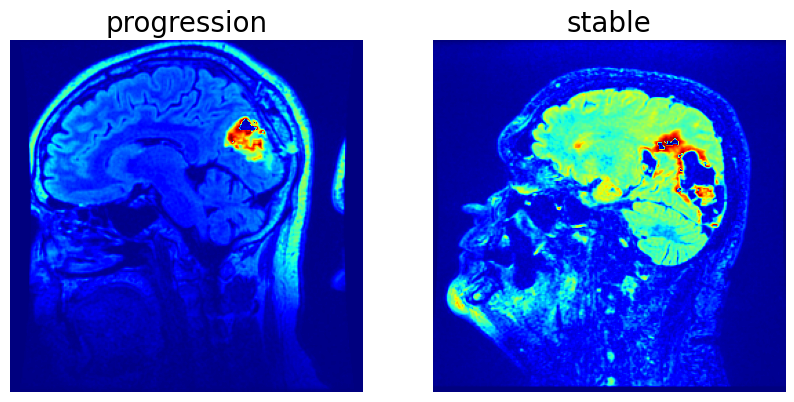

In [31]:
# Visualize the images
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(X_train[1][:,:,0], cmap = 'jet')
plt.axis('off')
plt.title(Y_train[1], fontsize=20)
plt.subplot(1,2,2)
plt.imshow(X_train[4][:,:,0], cmap = 'jet')
plt.axis('off')
plt.title(Y_train[4], fontsize=20)

In [32]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))


In [33]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 100

train_dataset = dataset_train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = dataset_val.batch(BATCH_SIZE)
test_dataset = dataset_test.batch(BATCH_SIZE)

In [34]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [35]:
# optimize performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

(256, 256, 3)


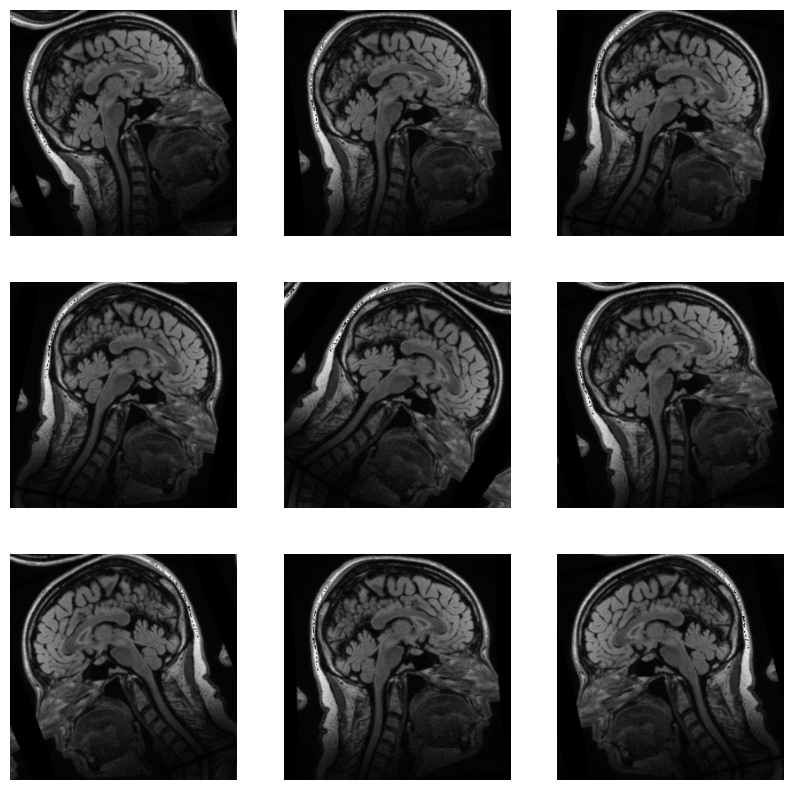

In [36]:
# image augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]

  print(first_image.shape)
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image,0))
    plt.imshow(augmented_image[0], cmap = 'jet')
    plt.axis('off')


In [37]:
# create base model from pre-trained model VGG16
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [38]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [39]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 512)


In [40]:
# setting the entire model's trainable flag to False will freeze all of them.
base_model.trainable = False

In [41]:
# add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [42]:
prediction_layer = tf.keras.layers.Dense(1, kernel_regularizer='l1')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [43]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [44]:
# compile the model
base_learning_rate = 0.0000001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                             

In [46]:
len(model.trainable_variables)

2

In [48]:
# train model
initial_epochs = 3
loss0, accuracy0 = model.evaluate(val_dataset)

UnimplementedError: ignored

In [53]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.22
initial accuracy: 0.52


In [54]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/3
5/5 [==============================] - 538s 109s/step - loss: 1.1909 - accuracy: 0.4340 - val_loss: 1.2179 - val_accuracy: 0.5172
Epoch 2/3
5/5 [==============================] - 545s 111s/step - loss: 1.1244 - accuracy: 0.5220 - val_loss: 1.2179 - val_accuracy: 0.5172
Epoch 3/3
5/5 [==============================] - 541s 110s/step - loss: 1.1265 - accuracy: 0.4969 - val_loss: 1.2179 - val_accuracy: 0.5172


In [55]:
model.save('/content/drive/MyDrive/Hackathon/vgg16_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


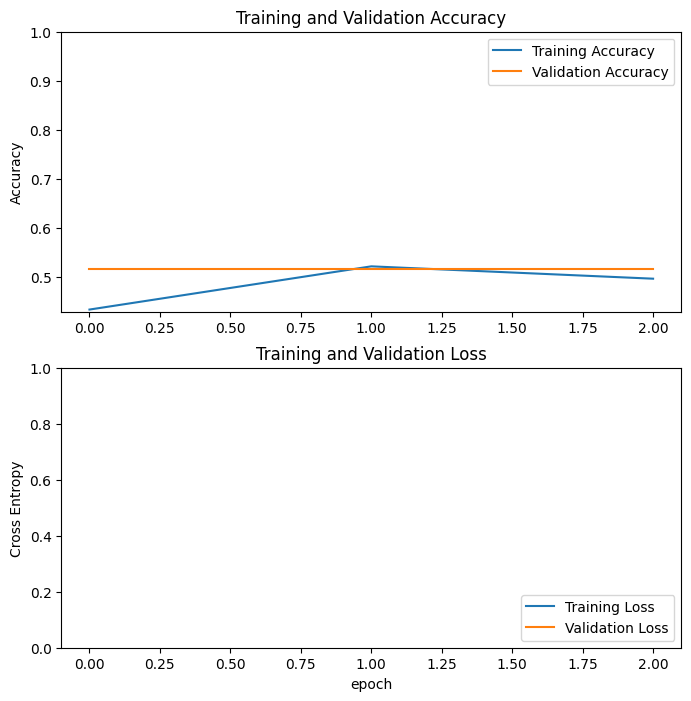

In [57]:
# Learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
# un-freeze the top layers of the model for fine tuning
base_model.trainable = True

In [59]:
# how many layers are in the base model?
print("Number of layers in the base model: ", len(base_model.layers))

# fine tune at layer 200
fine_tune_at = 200

# freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


In [60]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/5),
              metrics=['accuracy'])

In [61]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                             

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset)